July, 2018

**_Author: Dana Chermesh, Regional Planning intern_**

### US Metros comparison
comparison by the county level of 17 regions (CSA's) accross the country

### _Notebook no.4_
# Housing-Jobs balance
### - _Employment data were obtained from: BLS-QCEW_
Data Source: [Bureau of Labor Statistics, Quarterly Census of Employment and Wages](https://www.bls.gov/cew/datatoc.htm) (BLS-QCEW)
### - _Housing data were obtained from PEP/2017/housing_

---- 
# 0 - Imports

In [40]:
import requests
import pandas as pd
import numpy as np

from __future__ import print_function, division
import matplotlib.pylab as pl
# from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set_style('whitegrid')
# import json

# Spatial
import geopandas as gpd
import fiona
import shapely

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1 - Data acquisition

## Download directly from the BLS-QCEW website

The following code was downloaded from the [BLS-QCEW website](https://data.bls.gov/cew/doc/access/data_access_examples.htm#PYTHON), sapmle code for Python 3 ([Download](https://data.bls.gov/cew/doc/access/qcew_python_3x_example.zip))

In [26]:
import urllib.request
import urllib

# *******************************************************************************
# qcewCreateDataRows : This function takes a raw csv string and splits it into
# a two-dimensional array containing the data and the header row of the csv file
# a try/except block is used to handle for both binary and char encoding
def qcewCreateDataRows(csv):
    dataRows = []
    try: dataLines = csv.decode().split('\r\n')
    except er: dataLines = csv.split('\r\n');
    for row in dataLines:
        dataRows.append(row.split(','))
    return dataRows
# *******************************************************************************


# *******************************************************************************
# qcewGetAreaData : This function takes a year, quarter, and area argument and
# returns an array containing the associated area data. Use 'a' for annual
# averages. 
# For all area codes and titles see:
# http://www.bls.gov/cew/doc/titles/area/area_titles.htm
#
def qcewGetAreaData(year,qtr,area):
    urlPath = "http://data.bls.gov/cew/data/api/[YEAR]/[QTR]/area/[AREA].csv"
    urlPath = urlPath.replace("[YEAR]",year)
    urlPath = urlPath.replace("[QTR]",qtr.lower())
    urlPath = urlPath.replace("[AREA]",area.upper())
    httpStream = urllib.request.urlopen(urlPath)
    csv = httpStream.read()
    httpStream.close()
    return qcewCreateDataRows(csv)
# *******************************************************************************


# *******************************************************************************
# qcewGetIndustryData : This function takes a year, quarter, and industry code
# and returns an array containing the associated industry data. Use 'a' for 
# annual averages. Some industry codes contain hyphens. The CSV files use
# underscores instead of hyphens. So 31-33 becomes 31_33. 
# For all industry codes and titles see:
# http://www.bls.gov/cew/doc/titles/industry/industry_titles.htm
#
def qcewGetIndustryData(year,qtr,industry):
    urlPath = "http://data.bls.gov/cew/data/api/[YEAR]/[QTR]/industry/[IND].csv"
    urlPath = urlPath.replace("[YEAR]",year)
    urlPath = urlPath.replace("[QTR]",qtr.lower())
    urlPath = urlPath.replace("[IND]",industry)
    httpStream = urllib.request.urlopen(urlPath)
    csv = httpStream.read()
    httpStream.close()
    return qcewCreateDataRows(csv)
# *******************************************************************************


# *******************************************************************************
# qcewGetSizeData : This function takes a year and establishment size class code
# and returns an array containing the associated size data. Size data
# is only available for the first quarter of each year.
# For all establishment size classes and titles see:
# http://www.bls.gov/cew/doc/titles/size/size_titles.htm
#
def qcewGetSizeData(year,size):
    urlPath = "http://data.bls.gov/cew/data/api/[YEAR]/1/size/[SIZE].csv"
    urlPath = urlPath.replace("[YEAR]",year)
    urlPath = urlPath.replace("[SIZE]",size)
    httpStream = urllib.request.urlopen(urlPath)
    csv = httpStream.read()
    httpStream.close()
    return qcewCreateDataRows(csv)
# *******************************************************************************

# examples >> (hashed)

# Michigan_Data = qcewGetAreaData("2015","1","26000")
# Auto_Manufacturing = qcewGetIndustryData("2015","1","3361")
# SizeData = qcewGetSizeData("2015","6")

# # prints the industry_code in row 5.
# # remember row zero contains field names
# print(Michigan_Data[5][2])


# # prints the area_fips in row 1.
# # remember row zero contains field names
# print(Auto_Manufacturing[1][0])


# # prints the own_code in row 1.
# # remember row zero contains field names
# print(SizeData[1][1])

##  Reading in geo-coded dataset
created on a different notebook, please refer to _**0_US_Metro_Comparison_Geographies**_

In [27]:
geo = pd.read_csv('../Regional_USmetros_comparison/data/USmetros_full.csv').iloc[:,:-2] \
            .drop(['Unnamed: 0', 'SHAPE_AREA'], axis=1)
geo['STCO'] = geo['STCO'].apply(lambda x: '{0:0>5}'.format(x))

print(geo.shape)
geo.head()

(270, 4)


,CSA,CSA_name,County_name,STCO
0,488,"San Jose-San Francisco-Oakland, CA",Alameda,06001
1,488,"San Jose-San Francisco-Oakland, CA",Contra Costa,06013
2,488,"San Jose-San Francisco-Oakland, CA",Marin,06041
3,488,"San Jose-San Francisco-Oakland, CA",Napa,06055
4,488,"San Jose-San Francisco-Oakland, CA",San Benito,06069


In [28]:
geo.dtypes

CSA             int64
CSA_name       object
County_name    object
STCO           object
dtype: object

In [29]:
STCO = list(geo['STCO'])

print(type(STCO))
print(len(STCO))
STCO[:10]

<class 'list'>
270


['06001',
 '06013',
 '06041',
 '06055',
 '06069',
 '06075',
 '06077',
 '06081',
 '06085',
 '06087']

## Getting the 'annual_avg_emplvl' for all industries for every county in the major US metros of this analysis 
using the `qcewGetAreaData()` function built by the BLS QCEW

In [30]:
JobsCO17 = []

for i in STCO:
    county = qcewGetAreaData("2017","A", i)
    county = pd.DataFrame(county)
    county.columns = county.iloc[0]
    county = county[1:]
    county.columns = [i.replace('"', '') for i in county.columns]
    county = county.replace({'"':''}, regex=True)
    
    county = county[['area_fips','annual_avg_emplvl']][:1]
    
    JobsCO17.append(county)

JobsCO17 = pd.concat(JobsCO17)
JobsCO17.columns = ['STCO', 'Total_emp17']
JobsCO17 = JobsCO17.set_index('STCO')

print(JobsCO17.shape)
JobsCO17.head()

(270, 1)


,Total_emp17
STCO,
06001,772071
06013,366799
06041,115421
06055,76765
06069,16977


In [16]:
JobsCO17.to_csv('JobsCO17')

### _** Open data of the BLS QCEW is available from 2013 only; thus data for 2010 and 2000 were downloaded directly to the local machine**_

In [24]:
JobsCO10 = []

for i in STCO:
    county = qcewGetAreaDataOLD("2010","A", i)
    county = pd.DataFrame(county)
    county.columns = county.iloc[0]
    county = county[1:]
    county.columns = [i.replace('"', '') for i in county.columns]
    county = county.replace({'"':''}, regex=True)
    
    county = county[['area_fips','annual_avg_emplvl']][:1]
    
    JobsCO10.append(county)

JobsCO10 = pd.concat(JobsCO10)
JobsCO10.columns = ['STCO', 'Total_emp10']
JobsCO10 = JobsCO10.set_index('STCO')

print(JobsCO10.shape)
JobsCO10.head()

HTTPError: HTTP Error 404: Not Found

In [ ]:
JobsCO = JobsCO10.merge(JobsCO17, left_index=True,
                                 right_index=True)

print(JobsCO.shape)
JobsCO.head()

# Housing / Jobs Balance analysis

- PEP/2017/housing
- BLS QCEW 2017 annually

# 1. Counties - for mapping

## Total Employement 
- 'annual_avg_emplvl'

In [31]:
Jobs17 = pd.read_csv('JobsCO17')

Jobs17['STCO'] = Jobs17['STCO'].astype(str)
Jobs17['STCO'] = Jobs17['STCO'].apply(lambda x: '{0:0>5}'.format(x))

print(Jobs17.shape)
Jobs17.head()

(270, 2)


,STCO,Total_emp17
0,06001,772071
1,06013,366799
2,06041,115421
3,06055,76765
4,06069,16977


## Total Housing from PEP housing 2017

- Detailing on Population and Housing Estimates APIs: https://www.census.gov/data/developers/data-sets/popest-popproj/popest.2000-2010_Intercensals.html

- [examples for /data/2017/pep/housing](https://api.census.gov/data/2017/pep/housing/examples.html)

In [32]:
# HU2017 data for all counties in the US
totalHU17 = pd.read_json('https://api.census.gov/data/2017/pep/housing?get='+
                         'HUEST,GEONAME&for=county:*&DATE=10')

totalHU17.columns = totalHU17.iloc[0]
totalHU17 = totalHU17[1:]

totalHU17['state'] = totalHU17['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU17['county'] = totalHU17['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU17['STCO'] = totalHU17[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU17 = totalHU17.drop(['state', 'county','DATE'], axis=1)
totalHU17.columns = ['TotalHousing17','Name', 'STCO']

print(totalHU17.shape)
totalHU17.head(20)

(3142, 3)


,TotalHousing17,Name,STCO
1,372981,"Fairfield County, Connecticut",09001
2,379719,"Hartford County, Connecticut",09003
3,88285,"Litchfield County, Connecticut",09005
4,76339,"Middlesex County, Connecticut",09007
5,367195,"New Haven County, Connecticut",09009
6,123398,"New London County, Connecticut",09011
7,59729,"Tolland County, Connecticut",09013
8,49742,"Windham County, Connecticut",09015
9,49825,"Androscoggin County, Maine",23001
10,39911,"Aroostook County, Maine",23003


## Total Housing 2010 PEP 2010 -- Not in use 

This data set is called "int_housingunits 2000" and it includes both 2000 and 2010 Census Decennials data.

- API Call: api.census.gov/data/2000/pep/int_housingunits
- [examples](https://api.census.gov/data/2000/pep/int_housingunits.html)
- [variables](https://api.census.gov/data/2000/pep/int_housingunits/variables.html) in /data/2000/pep/int_housingunits/variables

In [33]:
# HU2010 data for all counties in the US, from PEP housing 2000-2010
totalHU10 = pd.read_json('https://api.census.gov/data/2000/pep/int_housingunits?get='+
                         'HUEST,GEONAME&for=county:*&DATE=10')

totalHU10.columns = totalHU10.iloc[0]
totalHU10 = totalHU10[1:]

totalHU10['state'] = totalHU10['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU10['county'] = totalHU10['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU10['STCO'] = totalHU10[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU10 = totalHU10.drop(['state', 'county', 'DATE'], axis=1)
totalHU10.columns = ['TotalHousing10','Name', 'STCO']

print(totalHU10.shape)
totalHU10.head()

(3143, 3)


,TotalHousing10,Name,STCO
1,358484,"Fairfield County, Connecticut",09001
2,372325,"Hartford County, Connecticut",09003
3,86754,"Litchfield County, Connecticut",09005
4,74172,"Middlesex County, Connecticut",09007
5,359866,"New Haven County, Connecticut",09009


## Total Pop + Total Housing 2010 from US Census Bureau Decennial Census 2010

In [64]:
# total HU for all counties in the US, 2010
totalHU10_sf = pd.read_json('https://api.census.gov/data/2010/sf1?get='+
                            'P0010001,H00010001,NAME&for=county:*')
totalHU10_sf.columns = totalHU10_sf.iloc[0]
totalHU10_sf = totalHU10_sf[1:]

totalHU10_sf['state'] = totalHU10_sf['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU10_sf['county'] = totalHU10_sf['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU10_sf['STCO'] = totalHU10_sf[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU10_sf = totalHU10_sf.drop(['state', 'county'], axis=1)
totalHU10_sf.columns = ['TotalPop00','TotalHousing00','Name', 'STCO']

print(totalHU10_sf.shape)
totalHU10_sf.head()

(3221, 4)


,TotalPop00,TotalHousing00,Name,STCO
1,54571,22135,Autauga County,01001
2,182265,104061,Baldwin County,01003
3,27457,11829,Barbour County,01005
4,22915,8981,Bibb County,01007
5,57322,23887,Blount County,01009


## Total Pop + Total Housing 2000 from US Census Bureau Decennial Census 2000

In [61]:
# total HU for all counties in the US, 2000
totalHU00 = pd.read_json('https://api.census.gov/data/2000/sf1?get='+
                         'P001001,H001001,NAME&for=county:*')
totalHU00.columns = totalHU00.iloc[0]
totalHU00 = totalHU00[1:]

totalHU00['state'] = totalHU00['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU00['county'] = totalHU00['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU00['STCO'] = totalHU00[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU00 = totalHU00.drop(['state', 'county'], axis=1)
totalHU00.columns = ['TotalPop00','TotalHousing00','Name', 'STCO']

print(totalHU00.shape)
totalHU00.head()

(3141, 4)


,TotalPop00,TotalHousing00,Name,STCO
1,43671,17662,Autauga County,01001
2,140415,74285,Baldwin County,01003
3,29038,12461,Barbour County,01005
4,20826,8345,Bibb County,01007
5,51024,21158,Blount County,01009


## Housing change 00-17

In [55]:
Hou00_17 = totalHU00.merge(totalHU17, on='STCO')

Hou00_17['TotalHousing17'] = Hou00_17['TotalHousing17'].astype(int)
Hou00_17['TotalHousing00'] = Hou00_17['TotalHousing00'].astype(int)

Hou00_17['NET00-17'] = Hou00_17['TotalHousing17'] - Hou00_17['TotalHousing00']
Hou00_17['%00-17'] = (Hou00_17['TotalHousing17'] - Hou00_17['TotalHousing00']) \
                    / Hou00_17['TotalHousing00']

Hou00_17 = Hou00_17.drop(['Name_x'], axis=1).set_index('Name_y')

print(Hou00_17.shape)
Hou00_17.head()

(3134, 6)


,TotalPop00,TotalHousing00,STCO,TotalHousing17,NET00-17,%00-17
Name_y,,,,,,
"Autauga County, Alabama",43671,17662,01001,23495,5833,0.330257
"Baldwin County, Alabama",140415,74285,01003,114162,39877,0.536811
"Barbour County, Alabama",29038,12461,01005,11970,-491,-0.039403
"Bibb County, Alabama",20826,8345,01007,9187,842,0.100899
"Blount County, Alabama",51024,21158,01009,24314,3156,0.149163


# Housing / Jobs Balance: County level for mapping

### Merging with geo

In [34]:
HOUSING17_CO = totalHU17.merge(geo, on='STCO').set_index('County_name')

HOUSING17_CO = HOUSING17_CO.drop('Name', axis=1)

print(HOUSING17_CO.shape)
HOUSING17_CO.head()

(270, 4)


,TotalHousing17,STCO,CSA,CSA_name
County_name,,,,
Fairfield,372981,09001,408,"New York-Newark, NY-NJ-CT-PA"
Litchfield,88285,09005,408,"New York-Newark, NY-NJ-CT-PA"
New Haven,367195,09009,408,"New York-Newark, NY-NJ-CT-PA"
Windham,49742,09015,148,"Boston-Worcester-Providence, MA-RI-NH-CT"
Barnstable,163533,25001,148,"Boston-Worcester-Providence, MA-RI-NH-CT"


In [35]:
HOUSING17_CO.dtypes

TotalHousing17    object
STCO              object
CSA                int64
CSA_name          object
dtype: object

## Merging with Jobs data

In [36]:
HouJobs17 = HOUSING17_CO.merge(Jobs17, on='STCO')

HouJobs17 = HouJobs17.drop('CSA_name', axis=1)
HouJobs17['TotalHousing17'] = HouJobs17['TotalHousing17'].astype(int)
HouJobs17['CSA'] = HouJobs17['CSA'].astype(str)

# HouJobs17 = HouJobs17.append(HouJobs17.sum(numeric_only=True), ignore_index=True)
HouJobs17['TotalHousing17'] = HouJobs17['TotalHousing17'].astype(int)
HouJobs17['Total_emp17'] = HouJobs17['Total_emp17'].astype(int)

HouJobs17['housing/jobs2017'] = HouJobs17['TotalHousing17'] / HouJobs17['Total_emp17']

print(HouJobs17.shape)
HouJobs17.head()

(270, 5)


,TotalHousing17,STCO,CSA,Total_emp17,housing/jobs2017
0,372981,09001,408,419998,0.888054
1,88285,09005,408,60508,1.459063
2,367195,09009,408,364067,1.008592
3,49742,09015,148,38776,1.282804
4,163533,25001,148,97180,1.682785


In [37]:
HouJobs17['fromAve'] = HouJobs17['housing/jobs2017'] - (HouJobs17['TotalHousing17'].sum() /
                                                        HouJobs17['Total_emp17'].sum())
HouJobs17.tail()

,TotalHousing17,STCO,CSA,Total_emp17,housing/jobs2017,fromAve
265,33451,53045,500,14018,2.386289,1.524851
266,346026,53053,500,302424,1.144175,0.282737
267,53800,53057,500,50708,1.060977,0.199539
268,310084,53061,500,283946,1.092053,0.230615
269,116820,53067,500,113258,1.031450,0.170012


In [38]:
HouJobs17['TotalHousing17'].sum() / HouJobs17['Total_emp17'].sum()

0.8614380337114965

## Reading in Geopgraphies df
Created through notebook #0: **US_Metro_Comparison_Geographies**

- **_Make sure to import GEOPANDAS_**

In [41]:
GEO = gpd.GeoDataFrame.from_file('exports/USmetros_rawNYC.shp')

GEO['STCO'] = GEO['STCO'].astype(str)
GEO['STCO'] = GEO['STCO'].apply(lambda x: '{0:0>5}'.format(x))

GEO['CSA_short'] = GEO['CSA_name'].str.split('-').str[0]
GEO['CSA_short'] = GEO['CSA_short'].replace(['San Jose'], ['San Francisco']) 

print(type(GEO))
print(GEO.shape)
print(GEO.geometry.name)
GEO.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(274, 7)
geometry


,SHAPE_AREA,STCO,County_nam,CSA,CSA_name,geometry,CSA_short
0,3.124167e+09,06001,Alameda,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13618345.0421 4551161.905000001, -1...",San Francisco
1,3.158013e+09,06013,Contra Costa,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13628818.5334 4574539.895900004, -1...",San Francisco
2,2.298070e+09,06041,Marin,488,"San Jose-San Francisco-Oakland, CA","(POLYGON ((-13694586.3189 4579361.395599999, -...",San Francisco
3,3.344885e+09,06055,Napa,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13652937.1333 4664335.483199999, -1...",San Francisco
4,5.596080e+09,06069,San Benito,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13541348.2494 4424341.478500001, -1...",San Francisco


## Merging Housing-Jobs data with .shp

In [54]:
HouJobs17_geo = GEO.merge(HouJobs17, on='STCO')

HouJobs17_geo = HouJobs17_geo.drop('CSA_y', axis=1)
HouJobs17_geo.rename(columns={'CSA_x':'CSA'}, inplace=True)
HouJobs17_geo = HouJobs17_geo.set_index('CSA')

print(type(HouJobs17_geo))
print(HouJobs17_geo.shape)
print(HouJobs17_geo.geometry.name)
HouJobs17_geo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(269, 10)
geometry


,SHAPE_AREA,STCO,County_nam,CSA_name,geometry,CSA_short,TotalHousing17,Total_emp17,housing/jobs2017,fromAve
CSA,,,,,,,,,,
488,3.124167e+09,06001,Alameda,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13618345.0421 4551161.905000001, -1...",San Francisco,606052,772071,0.784969,-0.076469
488,3.158013e+09,06013,Contra Costa,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13628818.5334 4574539.895900004, -1...",San Francisco,414007,366799,1.128703,0.267265
488,2.298070e+09,06041,Marin,"San Jose-San Francisco-Oakland, CA","(POLYGON ((-13694586.3189 4579361.395599999, -...",San Francisco,113126,115421,0.980116,0.118678
488,3.344885e+09,06055,Napa,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13652937.1333 4664335.483199999, -1...",San Francisco,55847,76765,0.727506,-0.133932
488,5.596080e+09,06069,San Benito,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13541348.2494 4424341.478500001, -1...",San Francisco,18876,16977,1.111857,0.250419


In [44]:
CSAs = HouJobs17_geo.groupby(['CSA', 'CSA_name']).count().reset_index().set_index('CSA')
CSAs = CSAs.iloc[:,:2]
CSAs.columns = ['CSA_name', 'numberCounties']

CSAs['CSA_short'] = CSAs['CSA_name'].str.split('-').str[0]
CSAs['CSA_short'] = CSAs['CSA_short'].replace(['San Jose'], ['San Francisco']) 

print(list(CSAs.index))
print(CSAs.shape)
CSAs

['122', '148', '176', '206', '216', '220', '288', '348', '370', '378', '408', '428', '488', '500', '548']
(15, 3)


,CSA_name,numberCounties,CSA_short
CSA,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",39,Atlanta
148,"Boston-Worcester-Providence, MA-RI-NH-CT",19,Boston
176,"Chicago-Naperville, IL-IN-WI",18,Chicago
206,"Dallas-Fort Worth, TX-OK",20,Dallas
216,"Denver-Aurora, CO",12,Denver
220,"Detroit-Warren-Ann Arbor, MI",10,Detroit
288,"Houston-The Woodlands, TX",14,Houston
348,"Los Angeles-Long Beach, CA",2,Los Angeles
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",7,Miami


In [45]:
# for plotting in the order I want to

CSAs_sorted = ['500','216', '220','378','148',
               '488','176',  '122','548','408',
               '348', '206', '288', '428', '370']

## Plotting Housing-Jobs Balance for all CSA's - county level
- 2010
- 2017
- change 10-17

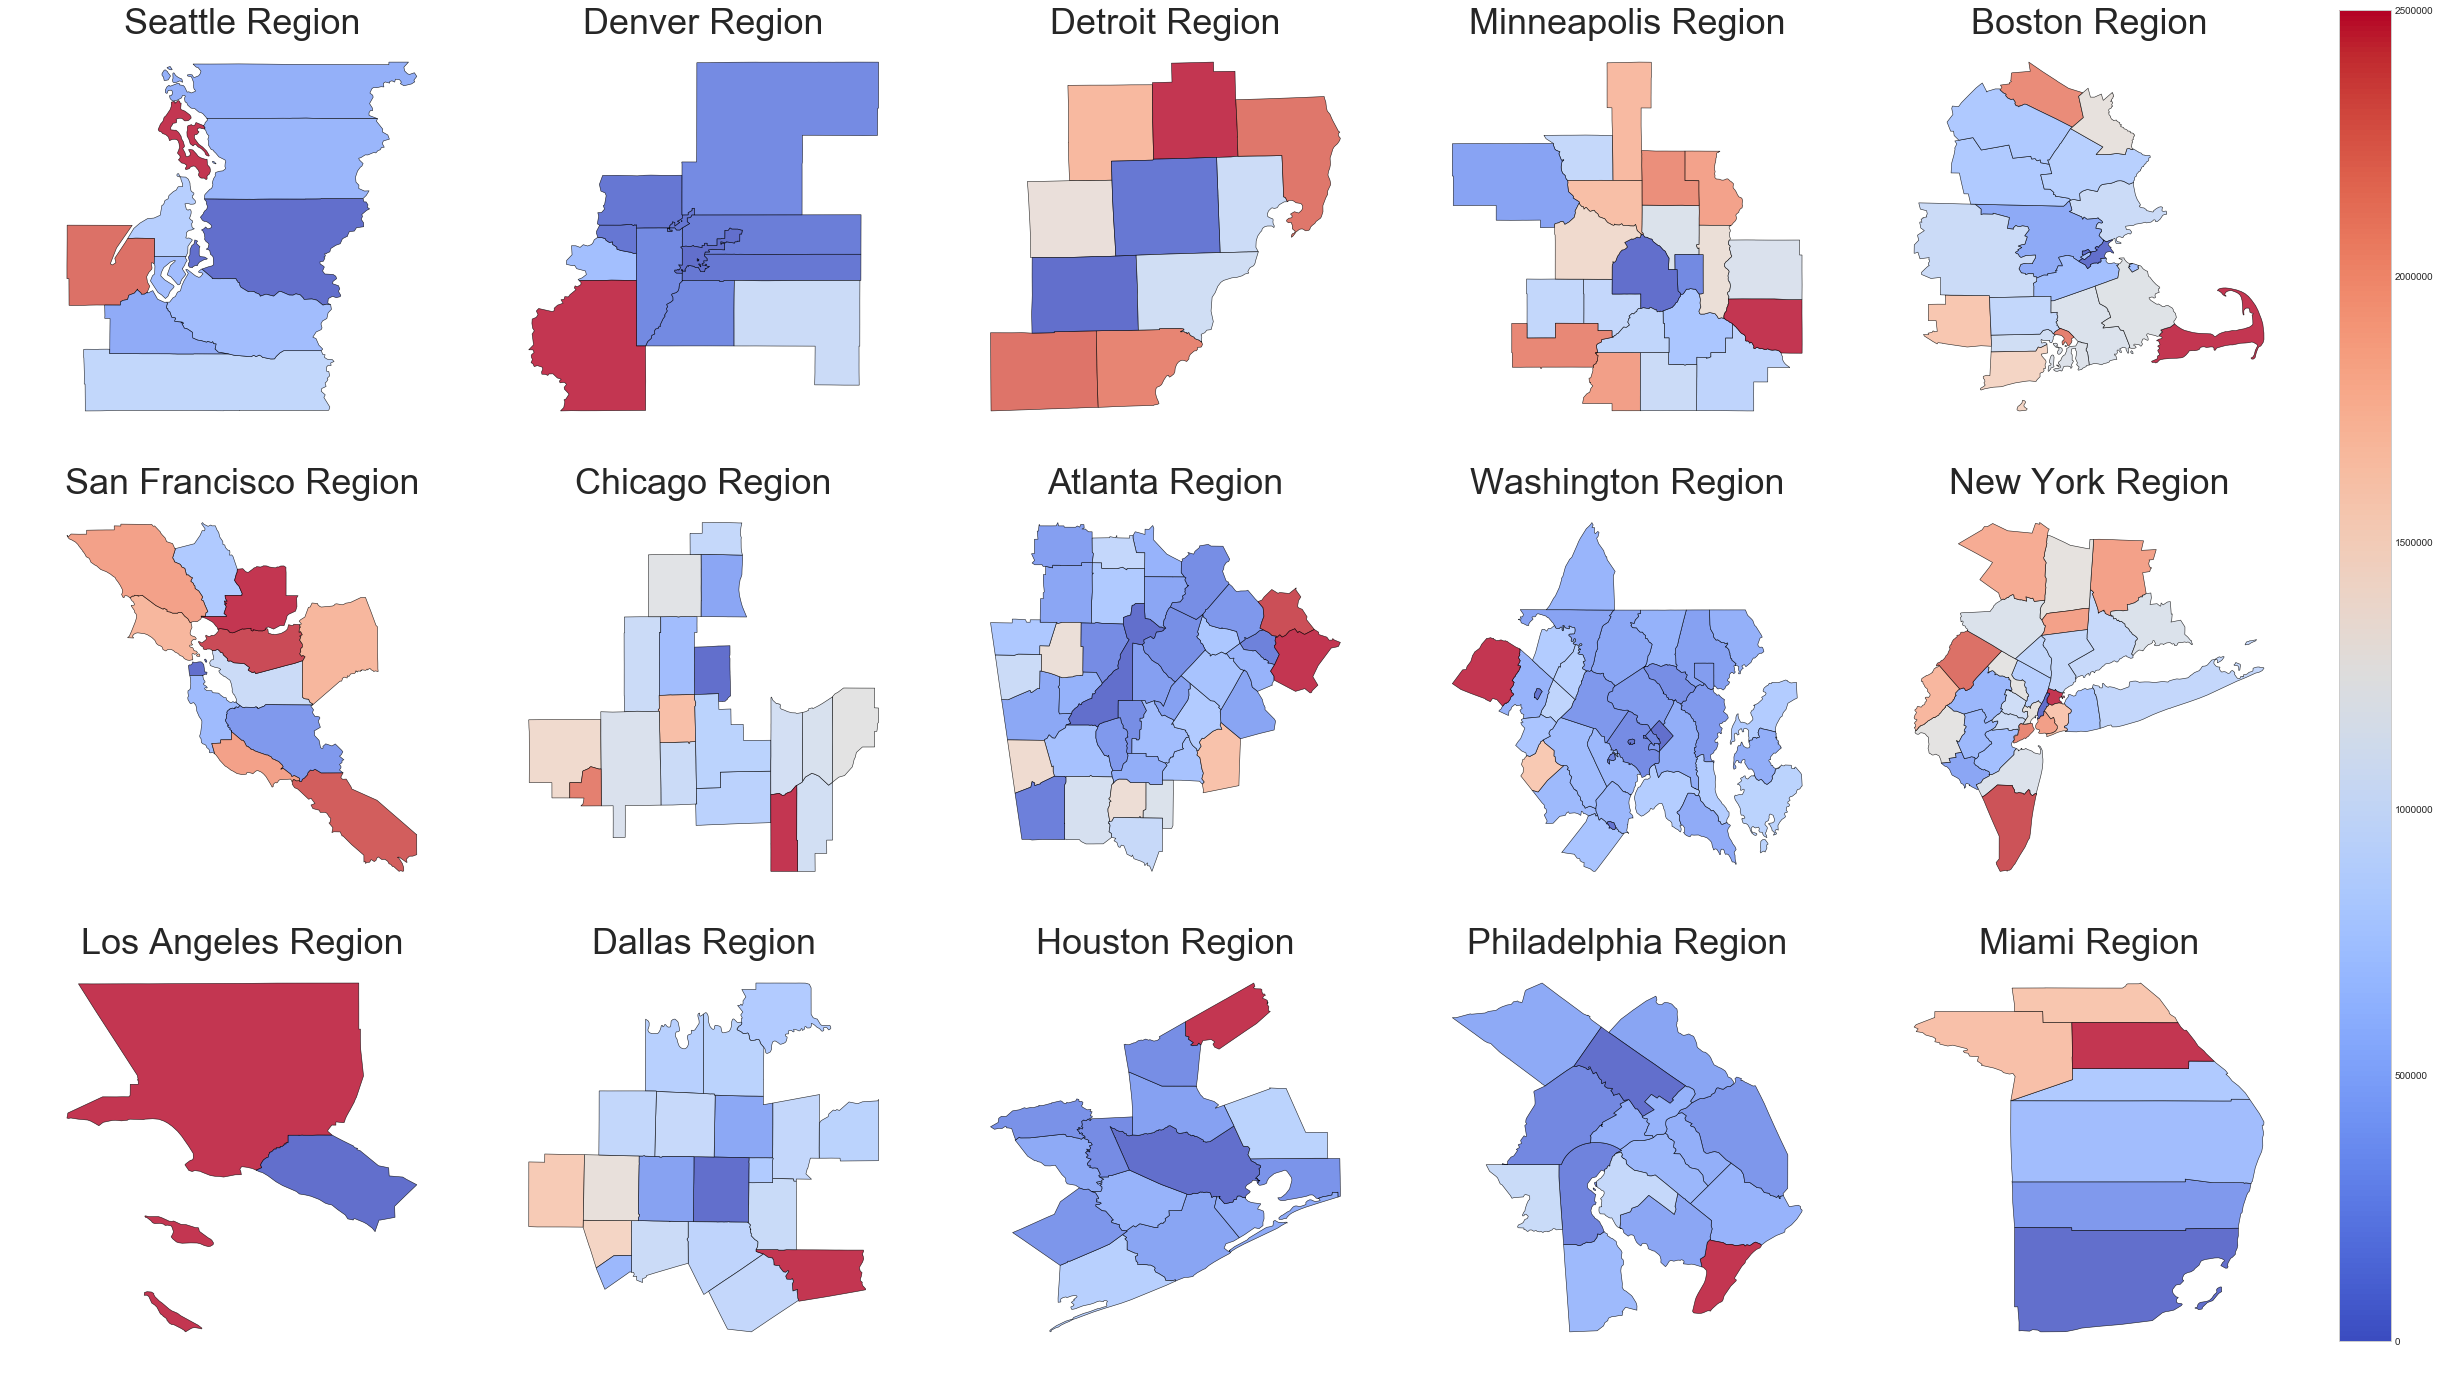

In [46]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = 0, 2500000

cax = fig.add_axes([0.92, 0.13, 0.018, .77])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical', values=None)


# 8 choroplets of seven major felonies + total
for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    HouJobs17_geo[HouJobs17_geo.index == CSAs_sorted[k]].plot(ax=ax, column='fromAve',
                                          cmap='coolwarm', edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')
    
plt.savefig("exports/HouJobs17.pdf", transparent=True)

------

## CSA's

In [47]:
HouJobs = pd.read_excel('BPS_HousingPermits_analysis.xlsx', 
                        sheet_name='HousingJobs_Balance')[:-2].set_index('Name')

HouJobs['housing / jobs 2010'] = HouJobs['housing / jobs 2010'].round(decimals=2)
HouJobs['housing / jobs 2016'] = HouJobs['housing / jobs 2016'].round(decimals=2)
HouJobs['housing / jobs 10-16 NET'] = HouJobs['housing / jobs 10-16 NET'].round(decimals=2)

HouJobs['CSA'] = HouJobs['CSA'].astype(int)

print(HouJobs .shape)
HouJobs 

(15, 5)


,CSA,FullName,housing / jobs 2010,housing / jobs 2016,housing / jobs 10-16 NET
Name,,,,,
New York,408,"New York-Newark, NY-NJ-CT-PA",0.92,0.84,-0.07
Los Angeles,348,"Los Angeles-Long Beach, CA",0.68,0.60,-0.08
Chicago,176,"Chicago-Naperville, IL-IN-WI",0.42,0.39,-0.03
Washington,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",0.84,0.80,-0.04
San Francisco,488,"San Jose-San Francisco-Oakland, CA",0.92,0.77,-0.14
Boston,148,"Boston-Worcester-Providence, MA-RI-NH-CT",0.92,0.84,-0.08
Dallas,206,"Dallas-Fort Worth, TX-OK",0.92,0.81,-0.11
Philadelphia,428,"Philadelphia-Reading-Camden, PA-NJ-DE-MD",0.97,0.93,-0.04
Houston,288,"Houston-The Woodlands, TX",0.94,0.86,-0.08


----

## Downloaded + cleaned data for years 2000-2017 
_Downloaded and munged by Dara Goldberg_


In [4]:
AlltractsGeo = pd.read_excel("data/ALL Tract Geo Codes.xlsx")
print(AlltractsGeo.shape)
AlltractsGeo.head()

(28066, 5)


,TRACT,CSA,STCO,ST,CO
0,10001041600,428,10001,10,1
1,10003001300,428,10003,10,3
2,10003011100,428,10003,10,3
3,10003011600,428,10003,10,3
4,10003013200,428,10003,10,3


In [58]:
BLS_CSA = pd.read_excel("../DCP Internship/US Major Metro Comparison_1990-2017_0614.xlsx", sheet_name='TOTAL_ALL 2017'
                       ,skiprows=[0,1,4,17,19]).iloc[:15,:10]

# BLS_CSA.iloc[:,3:] = BLS_CSA.iloc[:,3:].astype(int)
# BLS_CSA['CSA'][BLS_CSA['CSA'] == 'US000'] = 'FullUS'
# BLS_CSA['Name'][BLS_CSA['CSA'] == 'FullUS'] = 'FullUS'
# BLS_CSA['FullName'][BLS_CSA['CSA'] == 'FullUS'] = 'FullUS'


print(BLS_CSA.columns)
print(BLS_CSA.shape)
BLS_CSA

Index(['CSA ', 'Name', 'FullName', 1990, 1995, 2000, 2005, 2008, 2010, 2017], dtype='object')
(15, 10)


,CSA,Name,FullName,1990,1995,2000,2005,2008,2010,2017
0,408,NYC Metro,"New York-Newark, NY-NJ-CT-PA",9321054,8917354.0,9791295.0,9772119.0,10051111.0,9674206.0,10781580.0
1,122,Atlanta,"Atlanta--Athens-Clarke County--Sandy Springs, GA",1698322,2019355.0,2413348.0,2479868.0,2551161.0,2372462.0,2844759.0
2,148,Boston,"Boston-Worcester-Providence, MA-RI-NH-CT",3383370,3421906.0,3834847.0,3749830.0,3824178.0,3691234.0,4120001.0
3,176,Chicago,"Chicago-Naperville, IL-IN-WI",3978471,4185770.0,4534271.0,4415314.0,4478885.0,4192303.0,4628966.0
4,288,Houston,"Houston-The Woodlands, TX",1774129,1941664.0,2271793.0,2357555.0,2617373.0,2541934.0,2968025.0
5,378,Minneapolis,"Minneapolis-St. Paul, MN-WI",1485508,1658219.0,1878800.0,1892032.0,1916797.0,1823091.0,2063585.0
6,206,Dallas,"Dallas-Fort Worth, TX-OK",2074995,2319638.0,2852173.0,2851705.0,3078563.0,2951663.0,3592021.0
7,216,Denver,"Denver-Aurora, CO",996603,1174897.0,1426753.0,1407054.0,1482390.0,1405857.0,1729926.0
8,220,Detroit,"Detroit-Warren-Ann Arbor, MI",2233478,2353613.0,2531382.0,2368881.0,2198794.0,2022604.0,2312528.0
9,348,Los Angeles,"Los Angeles-Long Beach, CA",6509833,5971139.0,6793720.0,7122801.0,7225774.0,6655146.0,7754878.0


# 2 - Data cleaning and munging

## Total by Industry by Regions
## Total by Industry by Regions - City to region ratio / comparison
## Change by Industry by Regions 
## Change by Industry by Regions - City to region ratio / comparison
## Wages + change by Region (city/region)